# Práctica 7 - Parte 1: Clustering con K-Means y GMM


### Versión 1.0


### Nombre:


### Fecha:



Librerías y métodos que emplearemos en esta parte de la práctica (puedes importar más si lo consideras necesario):


In [1]:
import copy
from typing import List, Tuple

import ipywidgets as widgets
import matplotlib.pyplot as plt
import numpy as np
from matplotlib.axes import Axes
from matplotlib.collections import EllipseCollection
from scipy.stats import special_ortho_group
from sklearn.cluster import KMeans
from sklearn.mixture import GaussianMixture
from tqdm import tqdm

# descomenta %matplotlib qt si prefieres plots interactivos
# %matplotlib qt

Funciones útiles para visualización de resultados 2D

In [2]:
RAD2DEG = 180 / np.pi


def plot_gmm_results_2d(
    gmm,
    X: np.ndarray,
    colors: np.ndarray | List[str] | None = None,
    cmap: str = "Spectral",
    ax: Axes | None = None,
    std_intervals: Tuple[Tuple[float, float], ...] = ((1, 0.7), (2, 0.5), (3, 0.3)),
):
    """Visualización de los resultados de GMM con datos 2D

    Args:
        gmm: modelo entrenado de GaussianMixture
        X: (n_samples, 2) datos de entrada
        colors: colores para cada componente. Admite arrays (ncomps, 3) con valores RGB
            en [0, 1], o lista de strings con colores de matplotlib. Si es None, se
            usará el colormap especificado en cmap para crear los colores.
        cmap: colormap para crear los colores de las componentes
        ax: eje de matplotlib para plotear
        std_intervals: intervalos de desviación estándar para plotear las elipses y su
            alpha (transparencia) en [0, 1].

    Returns:
        ax: eje de matplotlib con el plot
    """
    means = gmm.means_  # (ncomp, 2)
    ncomps = means.shape[0]
    # (ncomp, 2, 2) / (ncomp, 2) / (2, 2) / (ncomp,)
    # full / diag / tied / spherical
    covs = gmm.covariances_

    # transforma las covarianzas a shape (ncomp, 2, 2)
    if gmm.covariance_type == "spherical":  # (ncomp,)
        covs = np.eye(2)[None] * covs[:, None, None]
    elif gmm.covariance_type == "diag":  # (ncomp, 2)
        covs = np.stack([np.diag(cov) for cov in covs])
    elif gmm.covariance_type == "tied":  # (2, 2)
        covs = np.stack([covs] * ncomps)

    if colors is None:
        colors = plt.get_cmap(cmap)(np.linspace(0, 1, ncomps))

    variances, eig_vecs = np.linalg.eigh(covs)
    std_devs = np.sqrt(variances)
    angles = np.arctan2(eig_vecs[:, 1, 0], eig_vecs[:, 0, 0]) * RAD2DEG

    if ax is None:
        _, ax = plt.subplots()

    # plot de elipses para cada componente de GMM
    for i, alpha in std_intervals:
        ax.add_collection(
            EllipseCollection(  # type: ignore
                widths=std_devs[:, 0] * i * 2,
                heights=std_devs[:, 1] * i * 2,
                angles=angles,
                units="xy",
                offsets=means,
                transOffset=ax.transData,
                color=colors,
                alpha=alpha,
            )
        )

    labels = gmm.predict(X)
    for i, (mean, color) in enumerate(zip(means, colors)):
        X_cluster = X[labels == i]
        c = color if isinstance(color, str) else [color]
        ax.scatter(X_cluster[:, 0], X_cluster[:, 1], c=c, s=5, alpha=0.5)
        ax.scatter(mean[0], mean[1], c=[color], s=50, marker="o", edgecolors="k")

    text = f"GMM\n#iters: {gmm.n_iter_}, log-likelihood: {gmm.lower_bound_:,.2f}"
    ax.text(
        0.01,
        0.99,
        text,
        va="top",
        ha="left",
        transform=ax.transAxes,
        fontsize=10,
    )
    return ax


def plot_kmeans_results_2d(
    kmeans,
    X: np.ndarray,
    colors_per_cluster: np.ndarray | List[str] | None = None,
    cmap: str = "Spectral",
    ax: Axes | None = None,
):
    """Visualización de los resultados de KMeans con datos 2D

    Args:
        kmeans: modelo entrenado de KMeans
        X: (n_samples, 2) datos de entrada
        colors_per_cluster: colores para cada cluster. Admite arrays (ncomps, 3) con valores RGB
            en [0, 1], o lista de strings con colores de matplotlib. Si es None, se
            usará el colormap especificado en cmap para crear los colores.
        cmap: colormap para crear los colores de los clusters
        ax: eje de matplotlib para plotear

    Returns:
        ax: eje de matplotlib con el plot
    """
    means = kmeans.cluster_centers_
    if colors_per_cluster is None:
        colors_per_cluster = plt.get_cmap(cmap)(np.linspace(0, 1, means.shape[0]))
    if ax is None:
        _, ax = plt.subplots()

    labels = kmeans.predict(X)
    for i, (mean, color) in enumerate(zip(means, colors_per_cluster)):
        X_cluster = X[labels == i]
        c = color if isinstance(color, str) else [color]
        ax.scatter(X_cluster[:, 0], X_cluster[:, 1], c=c, s=5, alpha=0.5)
        ax.scatter(mean[0], mean[1], c=[color], s=50, marker="o", edgecolors="k")

    text = f"KMeans\n#iters: {kmeans.n_iter_}, distortion: {kmeans.inertia_:,.2f}"
    ax.text(
        0.01,
        0.99,
        text,
        va="top",
        ha="left",
        transform=ax.transAxes,
        fontsize=10,
    )
    return ax


def visualize_subset_in_grid(
    images,
    subset=25,
    random=True,
    ncols=None,
    figsize=None,
    fig=None,
    ax=None,
):
    """Visualiza un subset de imágenes en una cuadrícula.

    Args:
        images: (n, 784) array con n imágenes 28x28 de Fasion-MNIST.
        subset: Si es un integer, número de imágenes a visualizar, si es una secuencia
            de enteros, visualiza las imágenes con esos índices.
        random: Si True y subset es un entero, las imágenes se seleccionarán
            aleatoriamente.
        ncols: Número de columnas de la cuadrícula. Si es None, se usará una grid
            cuadrada.
        figsize: (w, h) Tamaño de la figura.
        fig: Figura de matplotlib en la que visualizar las imágenes. Si es None, se
            creará una nueva figura.
        ax: Array de ejes de matplotlib en los que visualizar las imágenes. Si es None,
            se crearán nuevos ejes.
    """
    assert images.shape[1] == 784, "Las imágenes deben ser de 28x28 píxeles."

    if isinstance(subset, int):
        subset = min(subset, images.shape[0])
        if random:
            subset = np.random.choice(images.shape[0], subset, replace=False)
        else:
            subset = np.arange(subset)

    n = len(subset)
    if ncols is None:
        ncols = int(np.ceil(np.sqrt(n)))
    nrows = int(np.ceil(n / ncols))

    if fig is None or ax is None:
        fig, ax = plt.subplots(nrows, ncols, figsize=figsize)
    for i, axi in zip(subset, ax.ravel()):
        axi.imshow(images[i].reshape(28, 28), cmap="gray")
        # axi.axis("off")

    for axi in ax.ravel():
        axi.set(xticks=[], yticks=[])

    fig.tight_layout()
    return fig, ax

A continuación, extendemos las clases:
* [`KMeans`](https://scikit-learn.org/stable/modules/generated/sklearn.cluster.KMeans.html#sklearn.cluster.KMeans),
* [`GaussianMixture`](https://scikit-learn.org/stable/modules/generated/sklearn.mixture.GaussianMixture.html#gaussianmixture),

Con un método&mdash;`fit_with_hist`&mdash;que permite registrar el histórico de los parámetros <br>
correspondientes a cada clúster/componente Gaussiana ($k$) durante las iteraciones de sus <br>
algoritmos de estimación:
* `KMeans`:
  * medias $\mu_k$ (`cluster_centers_`), y
  * distorsión (`inertia_`).
* `GaussianMixture`:
  * medias $\mu_k$ (`means_`),
  * matrices de covarianza $\Sigma_k$ (`covariances_`),
  * probabilidad/pesos $\pi_k$ (`weights_`), y
  * log-verosimilitud (`lower_bound_`).


In [ ]:
import warnings
from sklearn.exceptions import ConvergenceWarning

# Como vamos a ir iteración a iteración, registrando los valores de los parámetros,
# para evitar warnings de convergencia en GMM, los desactivamos:
warnings.filterwarnings("ignore", category=ConvergenceWarning)


class KMeansWithHist(KMeans):
    """Wrapper simple sobre la clase `KMeans` de scikit-learn

    Este wrapper, añade el método `fit_with_hist` para registrar el histórico de
    `cluster_centers_` e `inertia_` a través de las iteraciones.
    Una vez ejecutado `fit_with_hist`, el atributo `historico` contiene un diccionario,
    con keys-values:
        - "centers": lista de arrays con los centros de los clusters en cada iteración.
        - "inertia": lista con los valores de la inercia en cada iteración.
        - "iter": lista con el número de iteración.

    Sin embargo, este wrapper es limitado y en realidad no refleja los valores exactos
    en cada iteración. Esto es debido a que la implementación de scikit-learn,
    antes de converger, realiza una iteración adicional que no podemos controlar desde
    este wrapper:
    https://github.com/scikit-learn/scikit-learn/blob/98ed9dc73a86f5f11781a0e21f24c8f47979ec67/sklearn/cluster/_kmeans.py#L736

    Una alternativa que sí permitiría trackear los valores exactos sería sobreescribir
    directamente las funciones y métodos de la propia clase `KMeans`. Sin embargo,
    esta alternativa es poco mantenible, y muy proclive a errores entre diferentes
    versiones de scikit-learn. Es decir, cualquier cambio futuro que hagan los
    desarrolladores de scikit-learn, podría romper nuestro código.
    """

    def fit_with_hist(self, X, y=None):
        """Ajuste de KMeans, registrando el histórico de `cluster_centers_` e `inertia_`"""
        self.historico = hist = {"centers": [], "inertia": [], "iter": []}
        self.fit(X)  # bootstrap de atributos
        # iteración inicial
        km = KMeans(
            n_clusters=self.n_clusters,  # type: ignore
            init=self.init,  # type: ignore
            n_init=1,
            max_iter=1,  # NOTE: iremos de iteración en iteración, por eso n_init=1
            random_state=self.random_state,  # type: ignore
        ).fit(X)

        centers = km.cluster_centers_
        inertia = km.inertia_
        labels = km.labels_

        hist["centers"].append(centers.copy())
        hist["inertia"].append(inertia)
        hist["iter"].append(0)

        # hasta convergencia, corremos una única iteración de kmeans, inicializando con los
        # centros obtenidos en la iteración anterior
        for i in range(1, self.max_iter):  # type: ignore
            km = KMeans(
                n_clusters=self.n_clusters,  # type: ignore
                init=centers,  # centers de la última iteración
                n_init=1,
                max_iter=1,
                random_state=self.random_state,  # type: ignore
            ).fit(X)

            new_centers = km.cluster_centers_
            new_inertia = km.inertia_
            new_labels = km.labels_

            hist["centers"].append(new_centers.copy())
            hist["inertia"].append(new_inertia)
            hist["iter"].append(i + 1)

            # checks de scikit-learn para comprobar convergencia
            center_shift = np.linalg.norm(centers - new_centers, axis=1)
            center_shift_tot = (center_shift**2).sum()
            if np.array_equal(labels, new_labels) or center_shift_tot <= km._tol:  # type:ignore # fmt: skip
                break

            centers, inertia, labels = new_centers, new_inertia, new_labels

        # sobreescribimos los parámetros ajustados, simulando una llamada a .fit
        self.cluster_centers_ = centers
        self.inertia_ = inertia
        self.labels_ = labels
        self.n_iter_ = len(hist["iter"])
        return self


class GMMWithHist(GaussianMixture):
    """Wrapper simple sobre la clase `GaussianMixture` de scikit-learn

    Este wrapper, añade el método `fit_with_hist` para registrar el histórico de
    `means_`, `covariances_`, `weights_` y `lower_bound_` a través de las iteraciones.
    Una vez ejecutado `fit_with_hist`, el atributo `historico` contiene un diccionario,
    con keys-values:
        - "means": lista de arrays con las medias de las componentes en cada iteración.
        - "covariances": lista de arrays con las matrices de covarianza en cada iteración.
        - "weights": lista de arrays con los pesos de las componentes en cada iteración.
        - "lower_bound": lista con los valores de la log-likelihood en cada iteración.
        - "iter": lista con el número de iteración.
    """

    def fit_with_hist(self, X, y=None):
        """Ajuste de GMM, registrando el histórico de parámetros por iteración"""
        self.historico = hist = {
            "means": [],
            "covariances": [],
            "weights": [],
            "lower_bound": [],
            "iter": [],
        }
        # el siguiente atributo es clave, pues nos permite evitar el reinicio de los
        # parámetros del modelo en cada `fit`, y por tanto nos permite poder trackear
        # los valores de los parámetros en cada iteración
        self.warm_start = True

        # forzamos max_iter=0, para guardar únicamente la inicialización de los parámetros
        max_iter = self.max_iter  # type: ignore
        self.max_iter = 0

        # Como vamos a ir iteración a iteración, registrando los valores de los parámetros,
        # para evitar warnings de convergencia en GMM, los desactivamos:
        warnings.filterwarnings("ignore", category=ConvergenceWarning)

        # inicialización / bootstrap
        self.fit(X)
        hist["means"].append(self.means_.copy())  # type: ignore
        hist["covariances"].append(self.covariances_.copy())  # type: ignore
        hist["weights"].append(self.weights_.copy())  # type: ignore
        hist["lower_bound"].append(self.lower_bound_)
        hist["iter"].append(0)

        # iremos iteración a iteración, por tanto:
        self.max_iter = 1

        for i in range(1, max_iter):
            self.fit(X)
            hist["means"].append(self.means_.copy())  # type: ignore
            hist["covariances"].append(self.covariances_.copy())  # type: ignore
            hist["weights"].append(self.weights_.copy())  # type: ignore
            hist["lower_bound"].append(self.lower_bound_)
            hist["iter"].append(i)
            # comprobamos convergencia
            if self.converged_:
                break
        # devolvemos de nuevo el atributo max_iter a su valor original
        self.max_iter = max_iter
        return self

## 1. Datos simulados

### 1. a) Creación de datos sintéticos

Primero vamos a explorar el comportamiento de los algoritmos con datos simulados. <br>
Revisa el código para entender cómo se han simulado los datos. 
1. ¿Qué tipo de distribución los está generando?
2. ¿es *GMM*, en principio, un modelo apropiado para modelar/ajustar a estos datos simulados?

Puedes probar a cambiar el código para tener una distribución de datos diferente, alterando:
* el número de componentes (`n_comps`),
* los parámetros de cada componente (controlados por `mean_lims` y `std_lims` en <br>
  la función `generate_gaussian_components`),
* o el número de puntos muestreados (`npts_per_gaussian`).

In [4]:
def generate_gaussian_components(
    ncomps: int,
    dim: int = 2,
    mean_lims: Tuple[float, float] = (-1, 1),
    std_lims: Tuple[float, float] = (0.01, 1),
    seed: int = 0,
) -> Tuple[np.ndarray, np.ndarray]:
    """Genera medias y covarianzas aleatorias para un dataset sintético"""
    rng = np.random.default_rng(seed)
    # meadias de las gaussianas
    sim_means = rng.uniform(*mean_lims, (ncomps, dim))
    # matrices de covarianza de las gaussianas: R^T * D * R
    random_rots = special_ortho_group.rvs(dim, ncomps, random_state=rng)
    random_diags = rng.uniform(*std_lims, (ncomps, dim)) ** 2
    sim_covs = random_rots.transpose(0, 2, 1) * random_diags[:, None] @ random_rots
    return sim_means, sim_covs


def generate_synthetic_data(
    sim_means: np.ndarray,
    sim_covs: np.ndarray,
    npts_per_gaussian: int = 500,
    do_plot: bool = False,
    seed: int = 1,
):
    """Genera un dataset de sintético a partir de medias y covarianzas Gaussianas"""
    ncomp = sim_means.shape[0]
    assert (
        sim_means.shape[0] == sim_covs.shape[0]
    ), "Por cada media, debe haber una covarianza"

    rng = np.random.default_rng(seed)

    X_orig = np.stack(
        [
            rng.multivariate_normal(sim_mean, sim_cov, npts_per_gaussian)
            for sim_mean, sim_cov in zip(sim_means, sim_covs)
        ],
        axis=0,
    )  # (ncomp, npts_per_gaussian, 2)
    labels_ground_truth = np.repeat(np.arange(ncomp), npts_per_gaussian)

    # dataset sintético final
    X = X_orig.reshape(-1, 2).copy()  # (ncomp*npts_per_gaussian, 2)
    # lo barajamos
    idx = rng.permutation(X.shape[0])
    X = X[idx]
    labels_ground_truth = labels_ground_truth[idx]

    if do_plot:
        fig, axs = plt.subplots(1, 2, sharey=True)
        color_per_gaussian = plt.get_cmap("Spectral")(np.linspace(0, 1, ncomp))
        axs[0].scatter(X[:, 0], X[:, 1], s=5, color="k")
        for i in range(ncomp):
            Xcomp = X[labels_ground_truth == i]
            axs[1].scatter(Xcomp[:, 0], Xcomp[:, 1], s=5, color=color_per_gaussian[i])
        axs[0].set_title("Sin labels (lo que KMeans/GMM usarán)")
        axs[1].set_title("Con labels")
        fig.tight_layout()
        plt.show()

    return X, labels_ground_truth

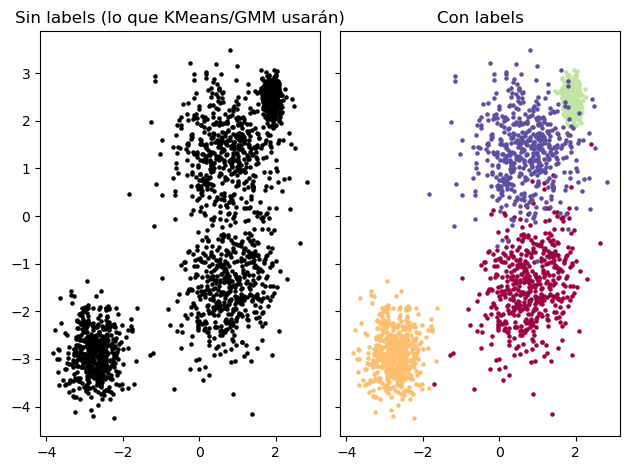

In [5]:
sim_means, sim_covs = generate_gaussian_components(
    ncomps=4, mean_lims=(-3, 3), std_lims=(0.1, 1.0), seed=0
)
X, labels_ground_truth = generate_synthetic_data(
    sim_means, sim_covs, npts_per_gaussian=500, do_plot=True
)

### 1. b) Comparación de K-Means y Mezcla de Gaussianas

Tras generar un dataset sintético, usa y compara los resultados tras ajustar [`KMeans`](https://scikit-learn.org/stable/modules/generated/sklearn.cluster.KMeans.html) y [`GMM`](https://scikit-learn.org/stable/modules/generated/sklearn.mixture.GaussianMixture.html) <br>
con el número correcto de clústers/componentes.

In [ ]:
# TODO: tu código
# n_clusters = ...
# kmeans = KMeans(...)
# gmm = GaussianMixture(...)

Para visualizar los resultados, os comendamos entender y usar (y modificar a vuestro gusto) <br>
las funciones:
* `plot_gmm_results_2d`
* `plot_kmeans_results_2d`

definidas anteriormente.

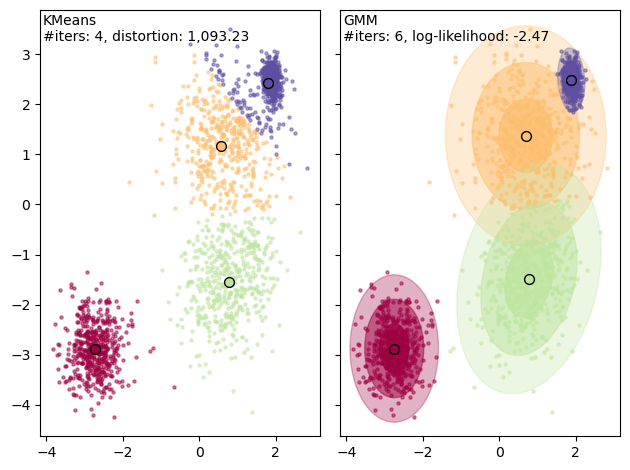

In [ ]:
# TODO: Código para visualizar los resultados

A partir de los wrappers `KMeansWithHist` y `GMMWithHist` definidos anteriormente, también <br> 
podemos visualizar la evolución de los parámetros de cada clúster/componente a través de sus <br> 
respectivas iteraciones las iteraciones:

In [ ]:
# KMeans
plt.close("all")

km_w_hist = KMeansWithHist(
    n_clusters=n_clusters,
    random_state=0,
    n_init=1,
    # init="k-means++",  # k-means++, random
    init="random",  # k-means++, random
).fit_with_hist(X)
hist_km = km_w_hist.historico


@widgets.interact(
    iter_=widgets.IntSlider(
        min=0, max=km_w_hist.n_iter_ - 1, value=0, continuous_update=False
    )
)
def plot_kmeans_iter(iter_):
    fig, ax = plt.subplots(figsize=(4, 5))
    kmeans_ = copy.deepcopy(km_w_hist)
    kmeans_.cluster_centers_ = hist_km["centers"][iter_]
    kmeans_.inertia_ = hist_km["inertia"][iter_]
    kmeans_.n_iter_ = hist_km["iter"][iter_]
    plot_kmeans_results_2d(kmeans_, X, ax=ax)
    ax.set_title(f"KMeans: iteración {iter_}")
    fig.tight_layout()
    plt.show()

interactive(children=(IntSlider(value=0, continuous_update=False, description='iter_', max=7), Output()), _dom…

In [ ]:
# GMM
plt.close("all")

gmm_hist = GMMWithHist(
    n_components=n_clusters,
    random_state=0,
    init_params="k-means++",  # kmeans, k-means++, random, random_from_data
    covariance_type="full",  # full, tied, diag, spherical
).fit_with_hist(X)
hist_gmm = gmm_hist.historico


@widgets.interact(
    iter_=widgets.IntSlider(
        min=0, max=len(hist_gmm["iter"]) - 1, value=0, continuous_update=False
    )
)
def plot_gmm_iter(iter_):
    fig, ax = plt.subplots(figsize=(4, 5))
    gmm_ = copy.deepcopy(gmm_hist)
    gmm_.means_ = hist_gmm["means"][iter_]
    gmm_.covariances_ = hist_gmm["covariances"][iter_]
    gmm_.weights_ = hist_gmm["weights"][iter_]
    gmm_.lower_bound_ = hist_gmm["lower_bound"][iter_]
    gmm_.n_iter_ = hist_gmm["iter"][iter_]
    plot_gmm_results_2d(gmm_, X, ax=ax)
    ax.set_title(f"GMM: iteración {iter_}")
    fig.tight_layout()
    plt.show()

interactive(children=(IntSlider(value=0, continuous_update=False, description='iter_', max=7), Output()), _dom…

### 1. c) Importancia de los hiperparámetros

Prueba a modificar la forma de inicializar los clústers/componentes en *k-Means* y *GMM*. <br>
En GMM también prueba a modificar el tipo de matrices de covarianza a estimar. <br>

Para hacer estas pruebas, puedes ayudarte de las visualizaciones anteriores. <br>
¿Observas diferencias en los resultados? ¿Por qué?

### 1. d) Selección de número de clusters / componentes

Ahora, asume que no conocemos el número de clústers / componentes de los datos simulados y <br>
por tanto trata de recuperarlos, tanto para *k-means* como para *GMM*.

Básate en criterios y métricas como [BIC](https://scikit-learn.org/stable/modules/generated/sklearn.mixture.GaussianMixture.html#sklearn.mixture.GaussianMixture.bic) (*GMM*) y [distorsión](https://scikit-learn.org/stable/modules/generated/sklearn.cluster.KMeans.html#:~:text=of%20each%20point-,inertia_,-float) (*k-means*) para tomar la decisión.

Además de esas curvas, como feedback visual adicional, puedes usar nuevamente las funciones <br>
`plot_gmm_results_2d` y `plot_kmeans_results_2d`.

In [ ]:
# TODO: tu código